In [1]:
# Update gensim to last version
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 2.8 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Objective: Find behaviour patterns in driver activities via clustering. (Manually) Classify this patterns to help recognize common faults while driving.

Example: Frequently missing B_T3 after a B_T2, making the hole sequence illegal.

Things worth considering:
- Variable length sequences.
- Activity representation. Possibilities:
  - activity, daytype, sequence, breaktype, token, legal -> [2,0,1,0,1]
  - Not sure if we should consider duration. In that case, should be normalized?
    - Maybe not because we are keeping token, and thus there would be redundant information
- Sequence representation. Possibilities:
  - List of activities (should span a day at most)
  - One activity at a time
  - Just one Sequence
- Distance function depends on the two previous points. Possibilities:
  - Substract duration and for the rest of variables only consider if they are the same. Probably different weights, as legal is more valuable.
- Categorical variables. We need to be careful with the distance function

---

Possible method:
1. Coding activities as word in a list representation
2. Group activities as sentences according to the Sequence column
3. Group sentences as documents, one for each driver
4. Apply sentence clustering or topic modelling (LDA?)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder

# BOW-TFIDF
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc

# D2V
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Clustering
from sklearn.cluster import KMeans

# Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Silhouette analysis
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [3]:
#########################################################################
# Load data
#########################################################################
data_path = "./combined-log.csv"
df = pd.read_csv(data_path, sep="\t",)

# To timestamp format
df.DateTimeStart = pd.to_datetime(df.DateTimeStart)
df.DateTimeEnd = pd.to_datetime(df.DateTimeEnd)

# Rename column
df = df_original = df.rename(columns={"#Driver":"Driver", "Duration(min)":"Duration"})


# To numerical
df.Legal = df.Legal.map({"yes": 1, "no": 0}) # Not sure if [-1,1] is better

# Drop columns
df = df.drop(columns=['Duration', 'ZenoInfo', "DateTimeStart", "DateTimeEnd", 'Week'])

df

,Driver,Activity,Day,DayType,Sequence,BreakType,Token,Legal
0,driver1,Break,1.0,ndd,first,split_1,B_T0,1
1,driver1,Driving,1.0,ndd,first,split_1,A,1
2,driver1,Other,1.0,ndd,first,split_1,A,1
3,driver1,Driving,1.0,ndd,first,split_1,A,1
4,driver1,Other,1.0,ndd,first,split_1,A,1
...,...,...,...,...,...,...,...,...
18167,driver132,Driving,6.0,ndd,second,uninterrupted,A,1
18168,driver132,Other,6.0,ndd,second,uninterrupted,A,1
18169,driver132,Driving,6.0,ndd,second,uninterrupted,A,1
18170,driver132,Other,6.0,ndd,second,uninterrupted,A,1


In [4]:
#########################################################################
# Transform data
# Encode each column as numeric and group them
#########################################################################

# The encoded columns are:
# Activity - DayType - Sequence - BreakType - Token - Legal

# Reorder columns
cols = ['Driver', 'Day', 'Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']
df = df[cols]

x = df.to_numpy()

# Encode into ordinal numbers
ordinalencoder_X = OrdinalEncoder(dtype=np.int8)
x[:,2:] = ordinalencoder_X.fit_transform(x[:,2:])

df_encoded = pd.DataFrame(x, columns=cols)

# Group columns into one (as string)
df_encoded['Encoding'] = df_encoded[df_encoded.columns[2:]].apply(
                            lambda x: '-'.join(x.dropna().astype(str)),
                            axis=1
                        )

# Remove encoded columns
df_encoded = df_encoded[['Driver','Day','Encoding']]

df_encoded

,Driver,Day,Encoding
0,driver1,1,0-1-0-1-1-1
1,driver1,1,1-1-0-1-0-1
2,driver1,1,3-1-0-1-0-1
3,driver1,1,1-1-0-1-0-1
4,driver1,1,3-1-0-1-0-1
...,...,...,...
18167,driver132,6,1-1-2-3-0-1
18168,driver132,6,3-1-2-3-0-1
18169,driver132,6,1-1-2-3-0-1
18170,driver132,6,3-1-2-3-0-1


In [5]:
# Group activities by day and join them in a list

# For each driver append all Encodings of one Day into a list
groups = df_encoded.groupby('Driver', sort=False) # False to keep driver ordering

# Each sentence is the sequence of activities in a day
corpus_lists = []

for name, group in groups:
  a = group.drop(columns='Driver')
  g = a.groupby('Day').cumcount()
  L = (a.set_index(['Day',g])
        .stack().groupby(level=0)
        .apply(lambda x: x.values))

  corpus_lists.extend(L)

In [8]:
print("Number of unique sequences: {}".format(len(df_encoded.Encoding.unique())))
# df_encoded.Encoding.unique()

Number of unique sequences: 152


In [9]:
#########################################################################
# Get embeddings
# Paragraph Vector (Doc2Vec)
# Word2vec for all the documents
#########################################################################

# Tag documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_lists)]

# Define and initialize model
doc2vec = Doc2Vec(documents, epochs=40, min_count=2, seed=1245)

# Train model
doc2vec.train(documents, 
              total_examples=doc2vec.corpus_count, 
              epochs=doc2vec.epochs)

In [ ]:
# TODO: Evaluate doc2vec model

# ranks = []
# second_ranks = []
# for doc_id in range(len(documents)):
#     inferred_vector = doc2vec.infer_vector(documents[doc_id].words)
#     sims = doc2vec.dv.most_similar([inferred_vector], topn=len(doc2vec.dv))
#     rank = [docid for docid, sim in sims].index(doc_id)
#     ranks.append(rank)

#     second_ranks.append(sims[1])

# import collections

# counter = collections.Counter(ranks)
# print(counter)

Counter({0: 58, 1: 19, 9: 14, 2: 14, 3: 11, 5: 11, 6: 7, 13: 7, 11: 7, 4: 6, 8: 6, 17: 5, 7: 5, 14: 5, 18: 4, 12: 4, 20: 4, 30: 3, 19: 3, 16: 3, 10: 3, 21: 2, 15: 2, 27: 2, 49: 2, 25: 2, 36: 2, 62: 2, 82: 1, 90: 1, 177: 1, 76: 1, 44: 1, 54: 1, 48: 1, 31: 1, 80: 1, 119: 1, 28: 1, 57: 1, 102: 1, 86: 1, 32: 1, 189: 1, 35: 1, 40: 1, 187: 1, 46: 1, 41: 1, 29: 1, 39: 1, 114: 1, 37: 1, 26: 1, 83: 1, 47: 1})


In [10]:
# Get embedding for each document
embeddings_d2v = []

for sentence in corpus_lists:
  embeddings_d2v.append(
      doc2vec.infer_vector(sentence)
  )

In [42]:
#########################################################################
# Get embeddings
# Bag-of-words and TF-IDF
# 
# It seem it will work without considering order (maybe because the tags already
# add information about it?)
# 
# https://stackoverflow.com/questions/50933591/how-to-perform-kmean-clustering-from-gensim-tfidf-values
#########################################################################

# Get the dictionary of our corpus
dictionary = Dictionary(corpus_lists)
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

# Transform into bow (bag-of-words)
# It's a small dictionary so I think this representation shouldn't be a problem
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_lists]

# Transform into tf-idf (term frequency – inverse document frequency)
tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

# Transform into sparse/dense matrix:
corpus_tfidf_dense = corpus2dense(corpus_tfidf, num_terms, num_docs).T   # Transposed!
# corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms, num_docs)

In [123]:
#########################################################################
# Visualize embeddings
#########################################################################

def plot_tsne(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # TSNE
  tsne = TSNE(n_components=2, random_state=12345)
  X_tsne = tsne.fit_transform(matrix)
  df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])

  ax.scatter(df_tsne['x'], df_tsne['y'], alpha=0.5, c=clusters)
  ax.set_title('TSNE')

# -------------------------------------------------------------------------

def plot_pca(matrix, clusters=None, ax=None):
  ax = ax or plt.gca()

  # PCA
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(matrix)
  df_pca = pd.DataFrame(X_pca, columns=['x', 'y'])

  ax.scatter(df_pca['x'], df_pca['y'], alpha=0.5, c=clusters)
  ax.set_title('PCA')
  
# -------------------------------------------------------------------------

def visualize_data(matrix, model_name, clusters=None, ax1=None, ax2=None):
  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,6))
  fig.suptitle('{} document plots'.format(model_name))

  plot_tsne(matrix, ax=ax1)
  plot_pca(matrix, ax=ax2)

  plt.show()

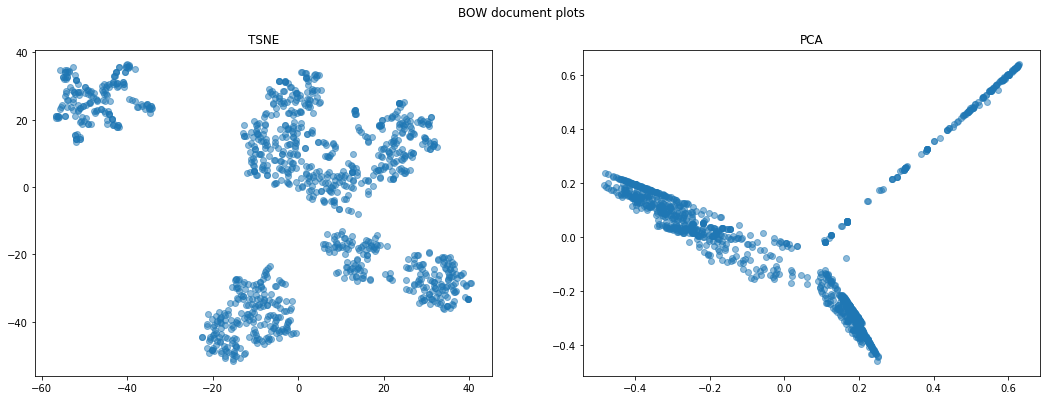

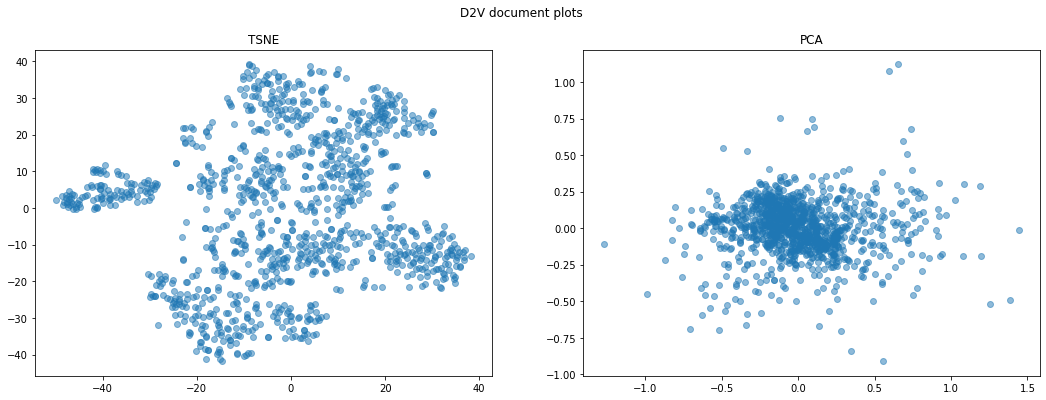

In [50]:
visualize_data(corpus_tfidf_dense, 'BOW')
visualize_data(embeddings_d2v, 'D2V')

In [73]:
#########################################################################
# Train data
# KMeans clustering (Euclidean distance)
#########################################################################

n_clusters = 10

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=12345)

clusters_bow = kmeans.fit_predict(corpus_tfidf_dense)
centroid_bow = kmeans.cluster_centers_

clusters_d2v = kmeans.fit_predict(embeddings_d2v)
centroid_d2v = kmeans.cluster_centers_

In [57]:
print("Mean Silhouette Coefficient - BOW: %0.3f" % silhouette_score(corpus_tfidf_dense, clusters_bow))
print("Mean Silhouette Coefficient - D2V: %0.3f" % silhouette_score(embeddings_d2v, clusters_d2v))

Mean Silhouette Coefficient - BOW: 0.168
Mean Silhouette Coefficient - D2V: 0.101


In [165]:
#########################################################################
# Silhouette analysis
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#########################################################################

def plot_silhouette(X, n_clusters, cluster_labels, ax=None):
  ax = ax or plt.gca()

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax.set_xlim([-0.2, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X, cluster_labels)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax.set_title("Silhouette plot for the various clusters.")
  ax.set_xlabel("Silhouette coefficient values")
  ax.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax.set_yticks([])  # Clear the yaxis labels / ticks

  xticks = [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, round(silhouette_avg,3)]
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticks, rotation=40)

In [146]:
def silhouette_analysis(X, range_n_clusters):

  for n_clusters in range_n_clusters:
      # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
      fig.set_size_inches(30, 10)

      # Initialize the clusterer with n_clusters value and a random generator
      clusterer = KMeans(n_clusters=n_clusters, random_state=12345)
      cluster_labels = clusterer.fit_predict(X)

      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

      plot_silhouette(X, n_clusters, cluster_labels, ax1)
      plot_tsne(X, clusters=colors, ax=ax2)
      plot_pca(X, clusters=colors, ax=ax3)

      plt.suptitle(
          "Silhouette analysis for KMeans clustering with n_clusters = %d"
          % n_clusters,
          fontsize=14,
          fontweight="bold",
      )


  plt.show()

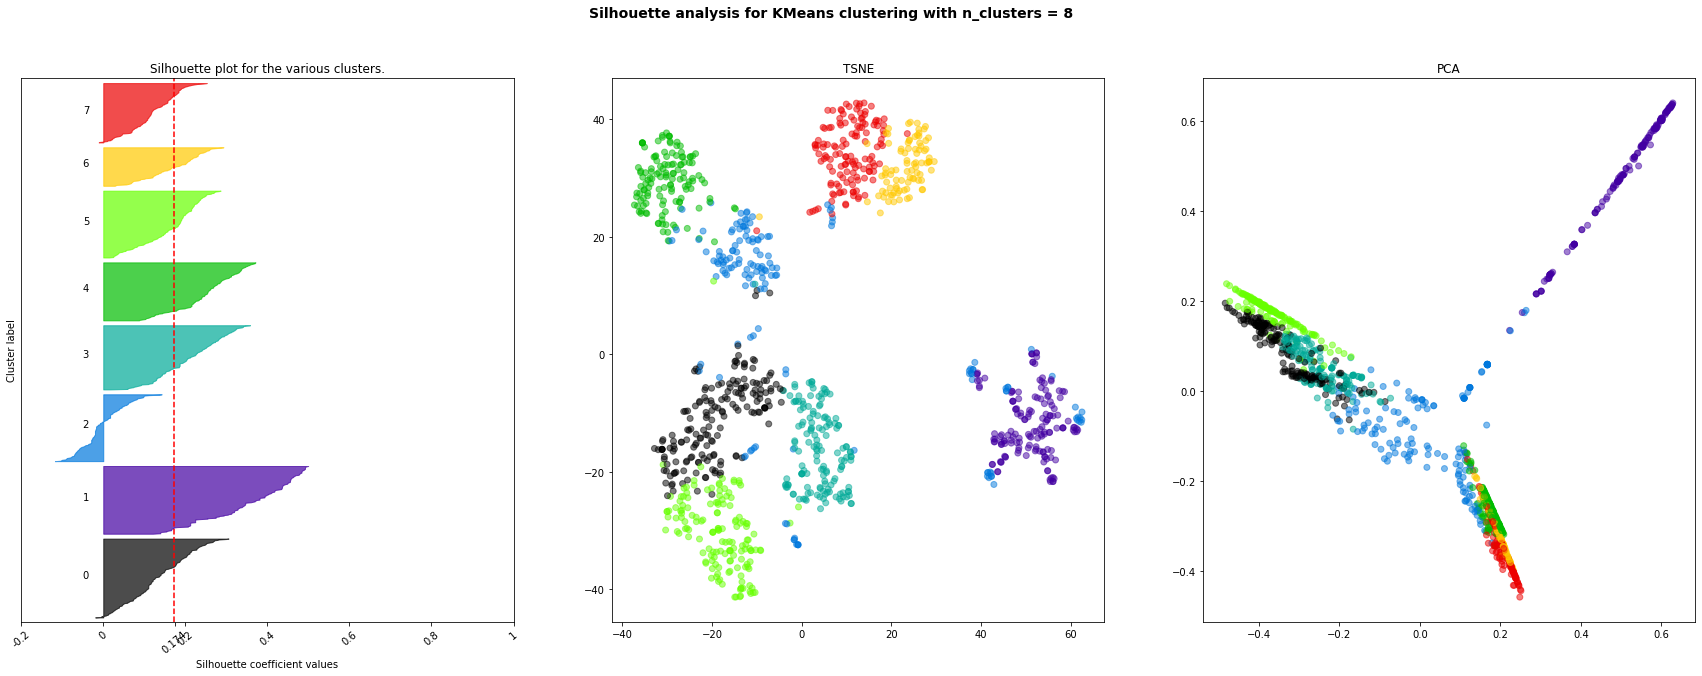

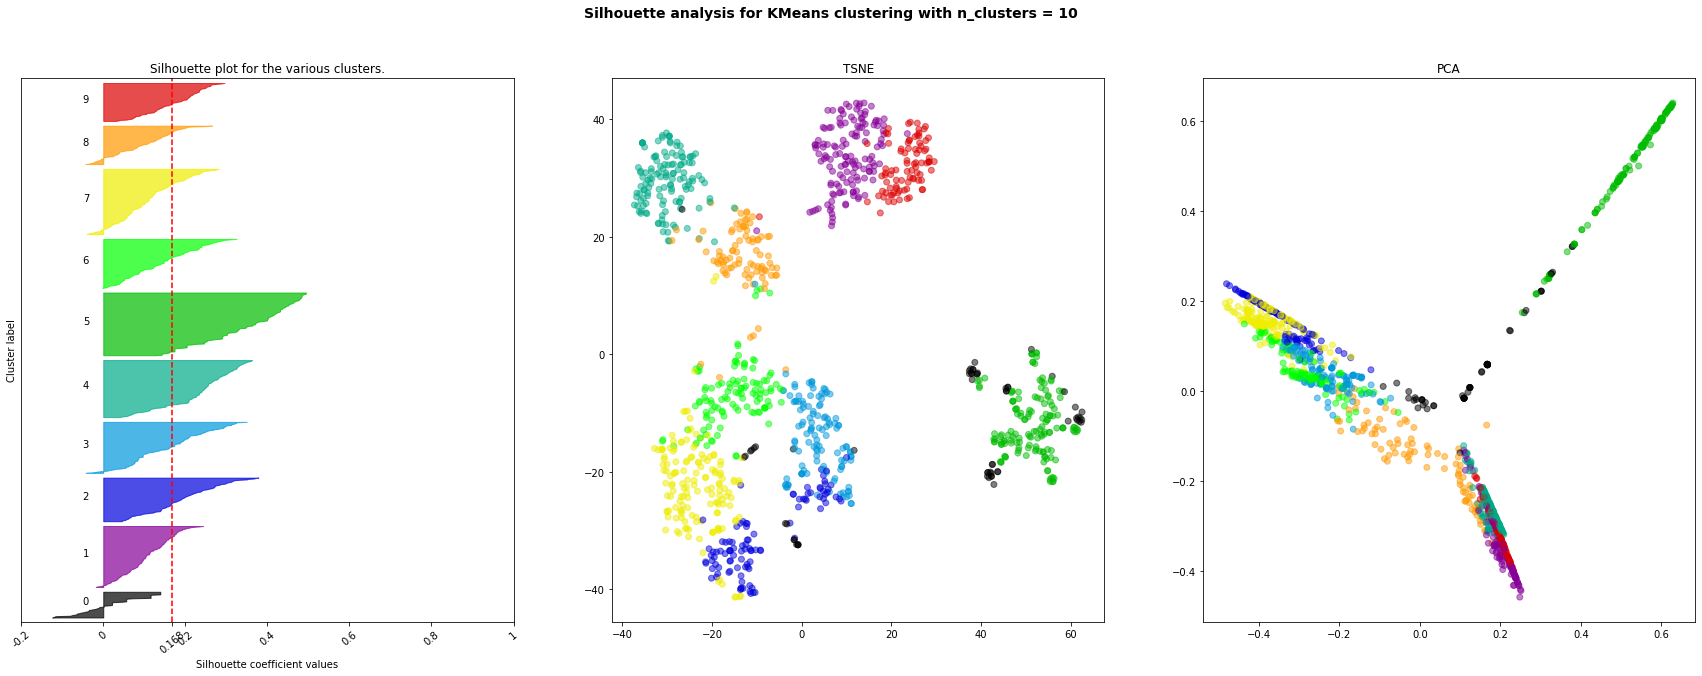

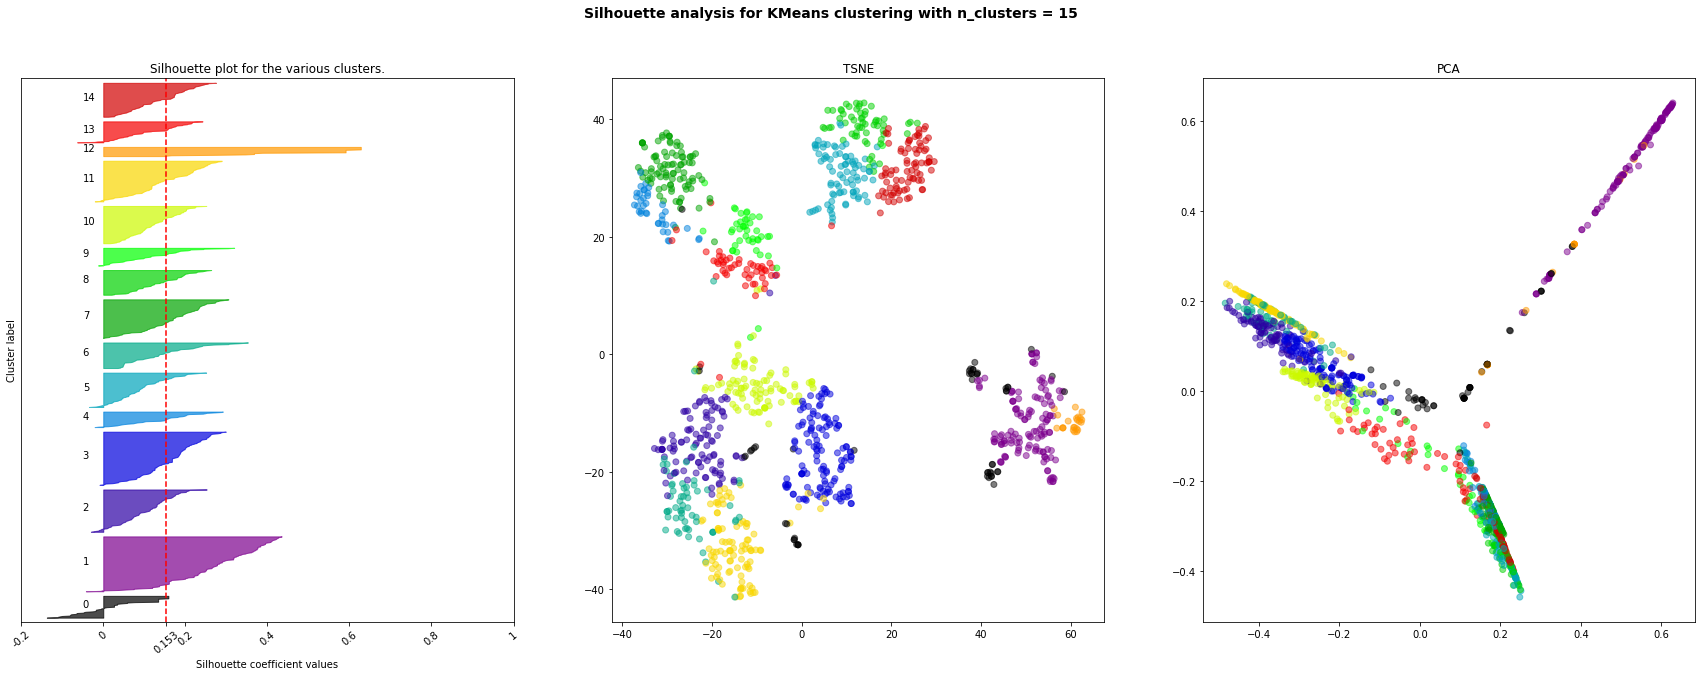

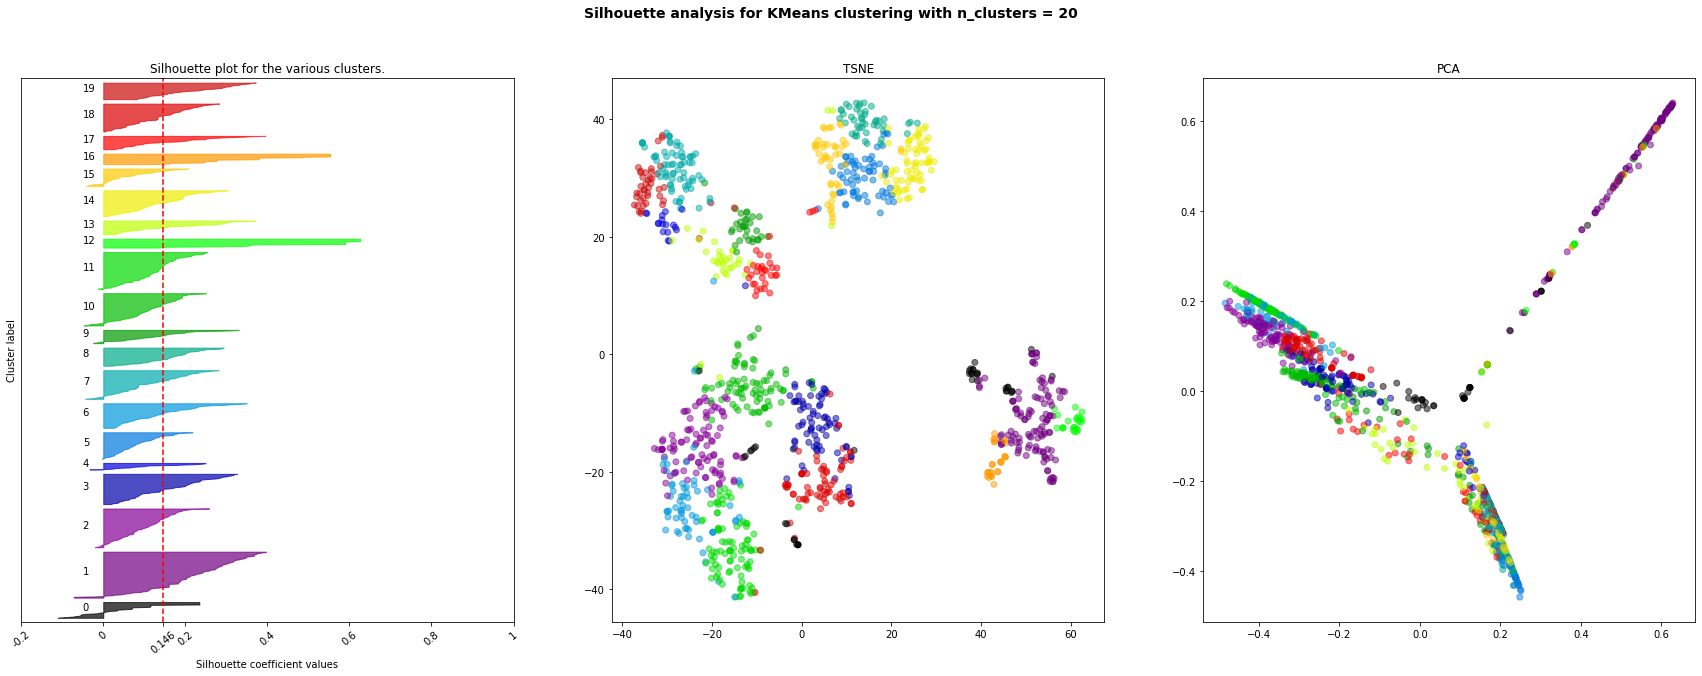

In [168]:
range_n_clusters = [8, 10, 15, 20]
silhouette_analysis(corpus_tfidf_dense, range_n_clusters)

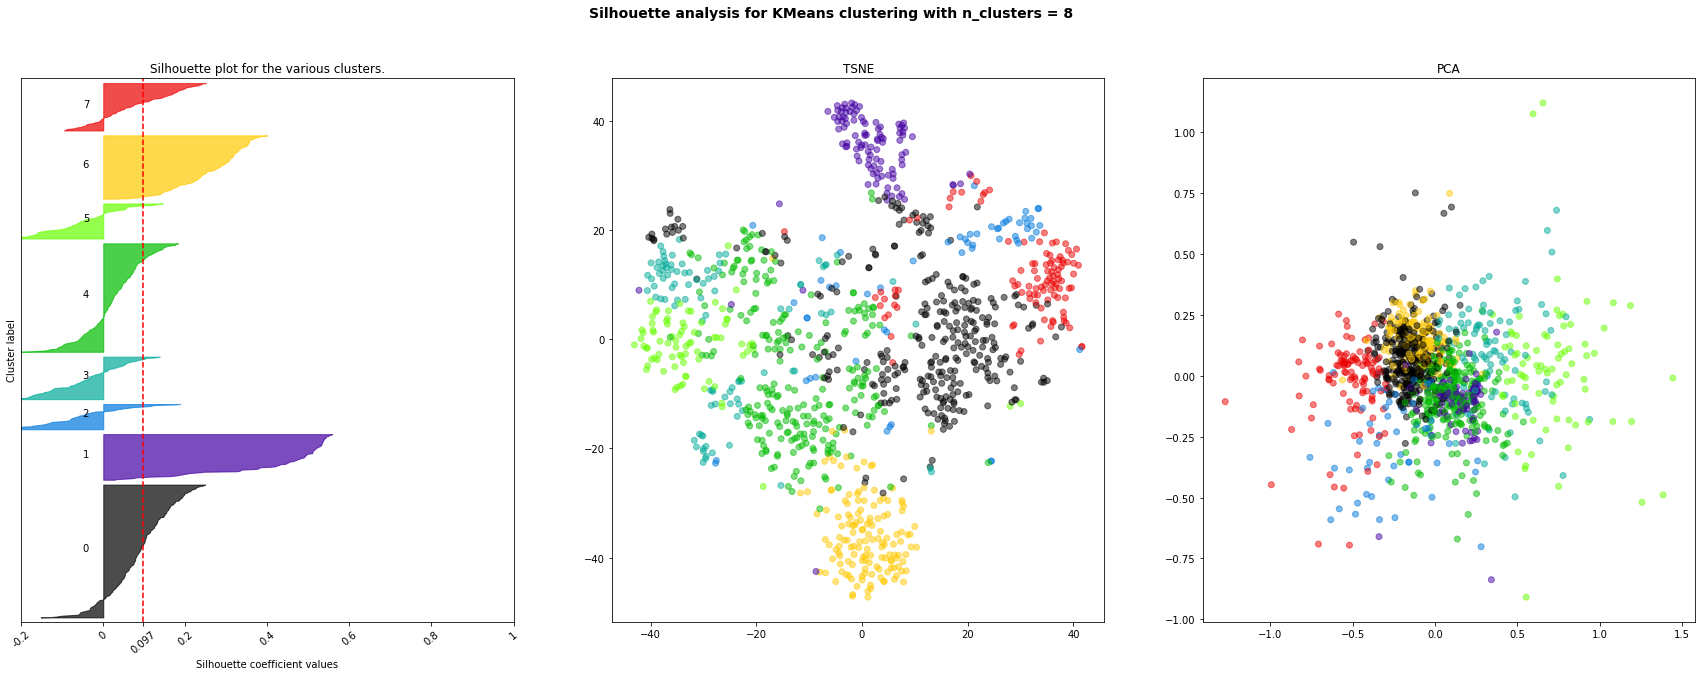

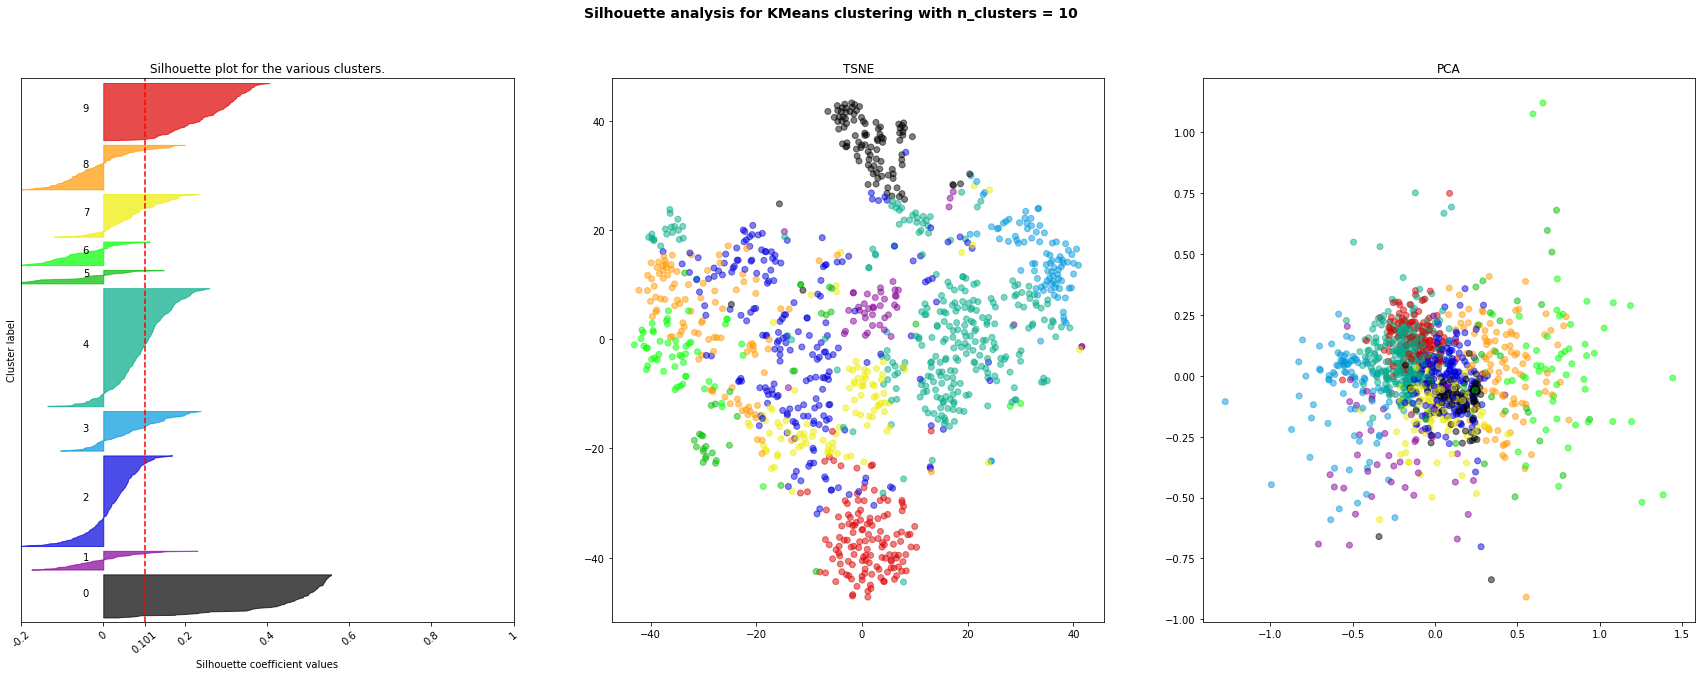

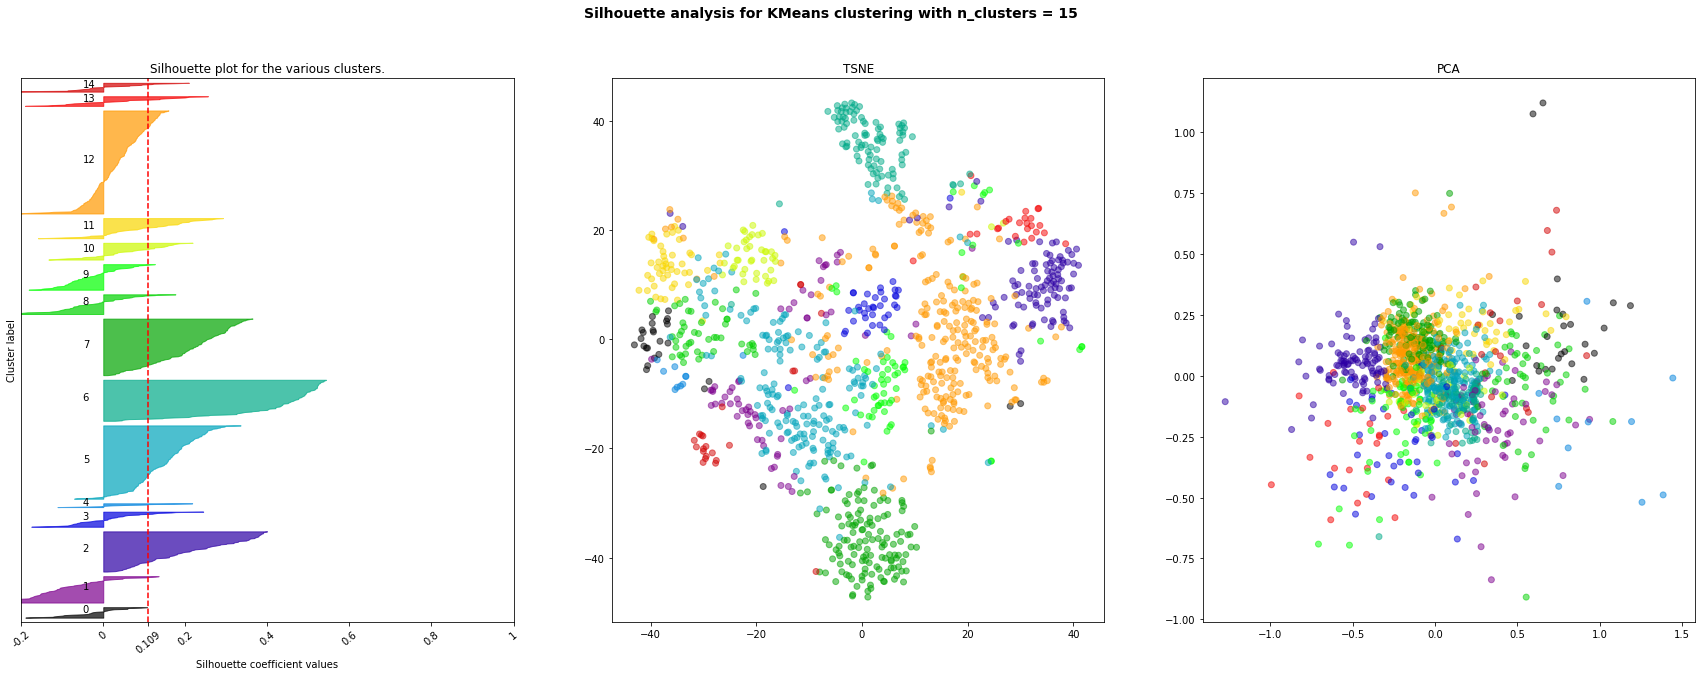

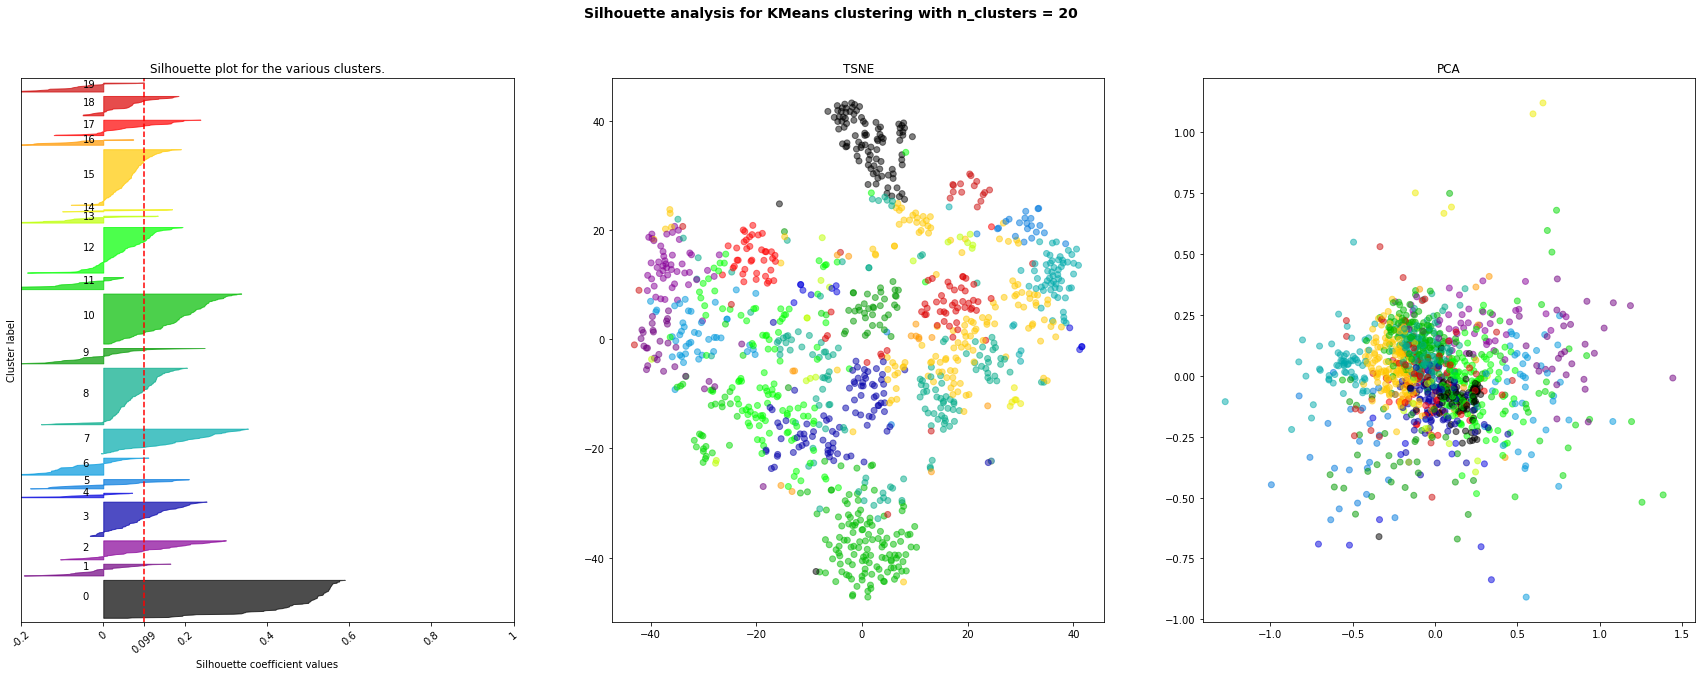

In [167]:
range_n_clusters = [8, 10, 15, 20]
silhouette_analysis(embeddings_d2v, range_n_clusters)

In [169]:
#########################################################################
# Train data
# DBscan clustering
#########################################################################

# The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.
# https://scikit-learn.org/stable/modules/clustering.html#dbscan

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric='cosine', eps=0.8, min_samples=2)
clusters_bow = dbscan.fit_predict(corpus_tfidf_dense)
centroid_bow = dbscan.core_sample_indices_

dbscan = DBSCAN(metric='cosine', eps=0.1, min_samples=2)
clusters_d2v = dbscan.fit_predict(embeddings_d2v)
centroid_d2v = dbscan.core_sample_indices_

# Cluster = -1 -> Noise

In [141]:
# print("Mean Silhouette Coefficient - BOW: %0.3f" % silhouette_score(corpus_tfidf_dense, clusters_bow))
dbscan = DBSCAN(metric='cosine', eps=0.3, min_samples=2)
clusters_d2v = dbscan.fit_predict(embeddings_d2v)
centroid_d2v = dbscan.core_sample_indices_

print("Mean Silhouette Coefficient - D2V: %0.3f" % silhouette_score(embeddings_d2v, clusters_d2v))
np.unique(clusters_d2v)

Mean Silhouette Coefficient - D2V: 0.183


array([-1,  0,  1,  2,  3])

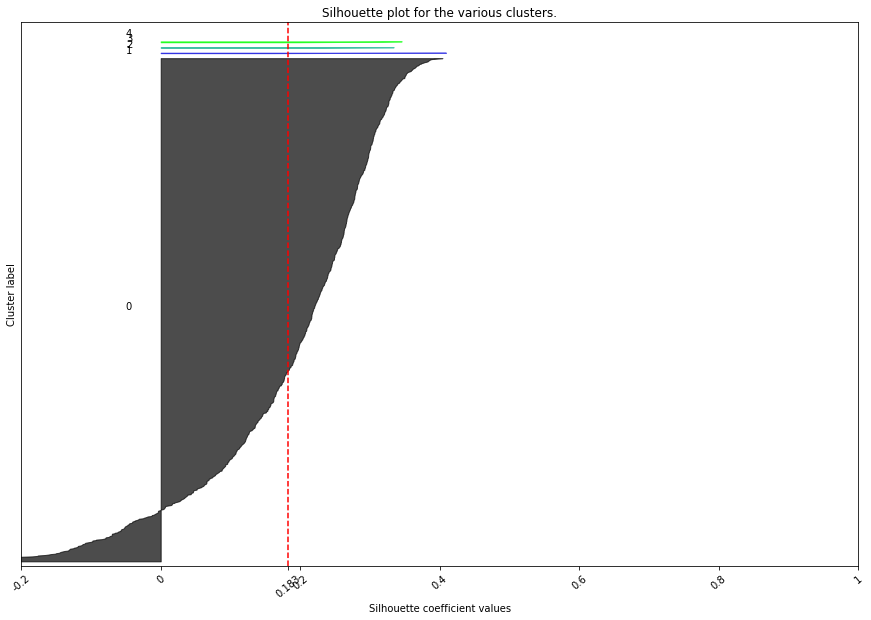

In [166]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

n_clusters = len(np.unique(clusters_d2v))
plot_silhouette(embeddings_d2v, n_clusters, clusters_d2v, ax)

plt.show()

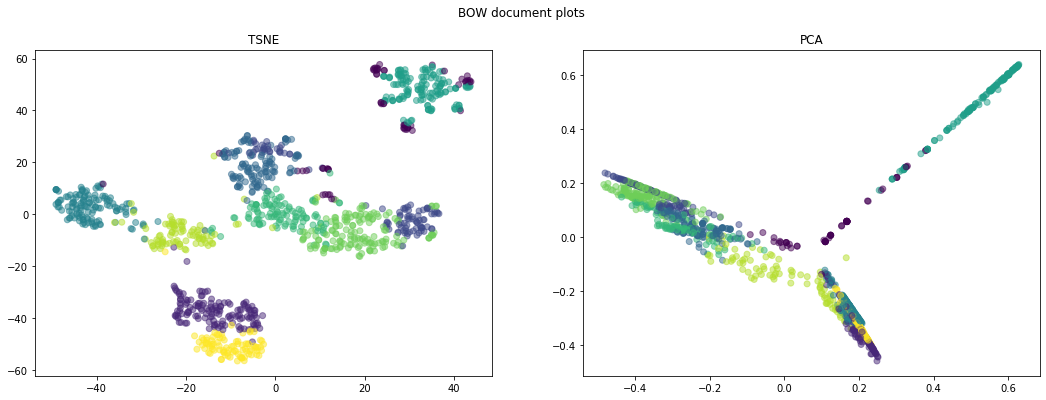

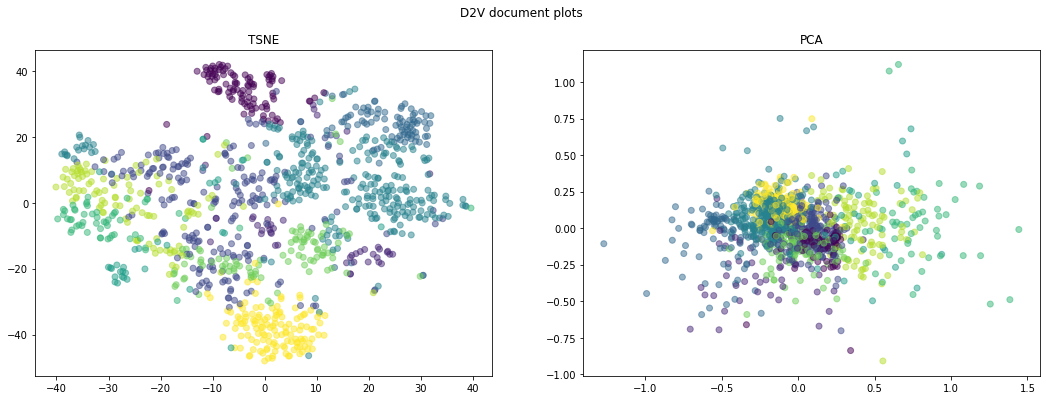

In [51]:
#########################################################################
# Plot clustered data
#########################################################################

visualize_data(corpus_tfidf_dense, 'BOW', clusters_bow)
visualize_data(embeddings_d2v, 'D2V', clusters_d2v)

In [ ]:
#########################################################################
# Get decoded centroids for Doc2Vec
#########################################################################

# Receives an encoding
def undo_encoding(x):
  l = x.split('-')
  return [int(e) for e in l]

# Receives a document
def v_undo_encoding(x):
  return [undo_encoding(e) for e in x]

# ------------------------------------------------------------------------------

def get_decoded_centroids_d2v(centroids):
  # For each centroid get the most similar document
  centroid_docs = []
  for cent in centroids:
    doc, similarity = doc2vec.dv.most_similar(positive = [cent], topn=1)[0]
    centroid_docs.append(doc)

  # Get the content of each doc
  docs = []
  for c_doc in centroid_docs:
    docs.append(corpus_lists[c_doc])

  # -----------------------------------------------

  # Get input format for inverse_encoder
  encoded_centroids = list(map(v_undo_encoding, docs))

  # Decode each centroid
  decoded_centroids = []
  for centroid in encoded_centroids:
    b = ordinalencoder_X.inverse_transform(centroid)
    
    decoded_centroids.append(b)

  # -----------------------------------------------
  # Get centroids as DataFrame

  cols = ['Activity', 'DayType', 'Sequence', 'BreakType', 'Token', 'Legal']

  df_centroids = pd.DataFrame(columns=cols)

  for c, number in zip(decoded_centroids, range(len(decoded_centroids))):
    df_c = pd.DataFrame(c, columns=cols)
    df_c["Cluster"] = number

    df_centroids = df_centroids.append(df_c)

  return df_centroids

In [ ]:
decoded_centroids_d2v = get_decoded_centroids_d2v(centroid_d2v)
decoded_centroids_d2v

,Activity,DayType,Sequence,BreakType,Token,Legal,Cluster
0,Driving,none,none,split_1,A,0,0.0
1,Break,none,none,split_1,B_T2,0,0.0
2,Driving,none,none,split_2,A,0,0.0
3,Break,none,none,split_2,B_T3,0,0.0
4,Driving,ndd,first,split_1,A,1,0.0
...,...,...,...,...,...,...,...
9,Driving,ndd,second,split_1,A,1,9.0
10,Break,ndd,second,split_1,B_T2,1,9.0
11,Driving,ndd,second,split_2,A,1,9.0
12,Other,ndd,second,split_2,A,1,9.0


In [ ]:
# Print results

# NOTE: Select here which clusters show
clusters = clusters_d2v

groups = df2.groupby(['Driver','Day'], sort=False)

results = []
for (name, group), cluster in zip(groups, clusters):
  results.append("{} in day {}: {}".format(name[0], int(name[1]), cluster))

# results

In [ ]:
#########################################################################
# Save results
#########################################################################

# NOTE: Select here which clusters save
clusters = clusters_d2v

# Final dataset columns
cols = df_original.columns.to_numpy()
cols = np.insert(cols, -1, 'Cluster')

df_out = pd.DataFrame(columns=cols)

groups = df_original.groupby(['Driver','Day'], sort=False)

# Add clusters to log
for (name, group), cluster in zip(groups, clusters):
  group["Cluster"] = cluster
  df_out = df_out.append(group)

df_out

,Driver,DateTimeStart,DateTimeEnd,Duration,Activity,Week,Day,DayType,Sequence,BreakType,Token,Legal,Cluster,ZenoInfo
0,driver1,2017-02-01 17:59:00,2017-02-01 18:13:00,14.0,Break,1.0,1.0,ndd,first,split_1,B_T0,1,2,NaN
1,driver1,2017-02-01 18:13:00,2017-02-01 18:16:00,3.0,Driving,1.0,1.0,ndd,first,split_1,A,1,2,NaN
2,driver1,2017-02-01 18:16:00,2017-02-01 18:18:00,2.0,Other,1.0,1.0,ndd,first,split_1,A,1,2,NaN
3,driver1,2017-02-01 18:18:00,2017-02-01 18:20:00,2.0,Driving,1.0,1.0,ndd,first,split_1,A,1,2,NaN
4,driver1,2017-02-01 18:20:00,2017-02-01 18:43:00,23.0,Other,1.0,1.0,ndd,first,split_1,A,1,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170,driver25,2017-01-15 09:56:00,2017-01-15 09:59:00,3.0,Driving,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN
4171,driver25,2017-01-15 09:59:00,2017-01-15 10:01:00,2.0,Other,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN
4172,driver25,2017-01-15 10:01:00,2017-01-15 10:08:00,7.0,Driving,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN
4173,driver25,2017-01-15 10:08:00,2017-01-15 10:12:00,4.0,Other,3.0,13.0,ndd,unique,uninterrupted,A,1,2,NaN


In [ ]:
# Save as CSV
df_out.to_csv("log-clustering.csv", sep="\t", index=False)

# Download
from google.colab import files
files.download("log-clustering.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save each cluster separated
groups = df_out.groupby(['Cluster'], sort=False)

# Add clusters to log
for name, group in groups:
  cluster = group['Cluster'].to_numpy()[0]
  
  path = "log-clustering-c{}.csv".format(cluster)
  group.to_csv(path, sep="\t", index=False)
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save d2v centroids
decoded_centroids_d2v.to_csv("log-clustering-centroids.csv", sep="\t", index=False)
files.download("log-clustering-centroids.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>